In [111]:
import sys
import evaluate

from metrics import *
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error as mse
import glob
import os
import cv2
import pandas as pd
from sklearn.svm import SVC
import numpy as np
import imp
import time
import random
import dlib
from imgaug import augmenters as iaa
#imp.reload(tiny)
import metrics
imp.reload(metrics)
%matplotlib inline

In [2]:
weights_path = './Tiny_Faces_in_Tensorflow/hr_res101.pkl'
data_dir = './tiny/data/widerface/WIDER_val/images/28--Sports_Fan/'
out_dir = './Tiny_Faces_in_Tensorflow/out_test/'

In [3]:
data_folder = './tiny/data/widerface/WIDER_val/images/'

In [4]:
frame = glob.glob(data_dir+'*')[15]
original_image = cv2.imread(frame)[:,:,::-1]

### Annotations

In [4]:
with open('./tiny/data/widerface/wider_face_val_bbx_gt.txt') as f:
    annotation_file = [k.strip() for k in f.readlines()]

In [6]:
# open annotations
image_name = [k for k in annotation_file if '--' in k]
original_annot = {} 
# original_annot[name] = [(x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose)]
for name in image_name:
    n_index = annotation_file.index(name)
    n_pictures = int(annotation_file[n_index+1])
    original_annot[name] = annotation_file[n_index+2:n_index+2+n_pictures]

In [7]:
resized_annot = {}
dico_img = {}

# resizing ground truth and images
for r in [1, 2, 4, 8]:
    resized_annot[r] = {}
    for name, value in original_annot.items():
        temp = []
        for l in value:
            (x1, y1, w, h, _, _, _, _, _, _) = map(int, l.split())
            temp.append(list(map(lambda x:int(x/r), (x1, y1, w, h))))
        resized_annot[r][name] = temp
        
    resized_shape = tuple(map(lambda x:int(x/r), original_image.shape[:2]))
    dico_img[r] = cv2.resize(original_image, resized_shape[::-1])

In [8]:
predictions = {}
for rate, elem in dico_img.items():
    with tf.Graph().as_default():
        predictions[rate] = evaluate.evaluate(weight_file_path=weights_path, img=elem)

### Plotting bounding box

In [9]:
pic = frame.replace(data_dir, '')
img_truth = cv2.imread(data_folder + get_folder_name(pic) + pic)[:,:,::-1]

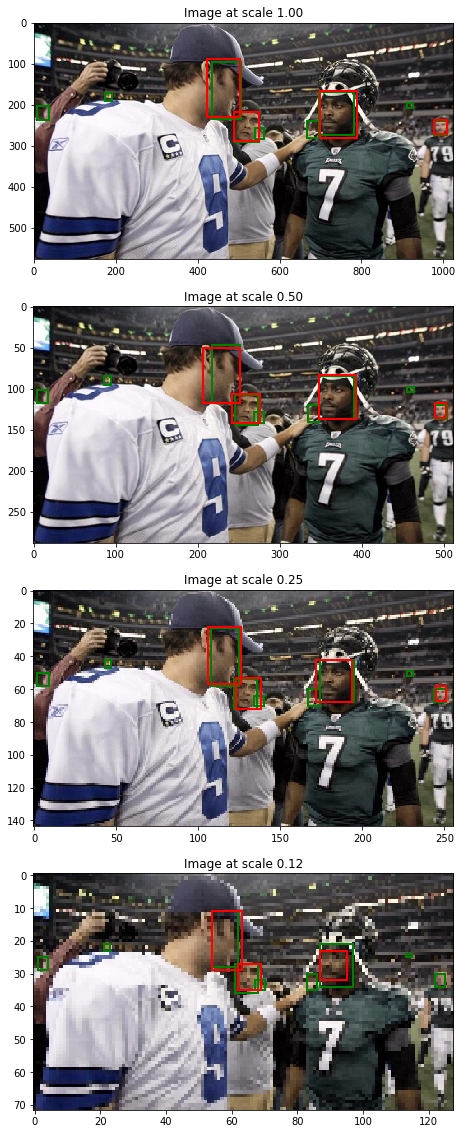

In [11]:
f, ax = plt.subplots(figsize=(15,20), nrows=4)

# plot the ground truth bounding boxes
for i, (rate, values) in enumerate(resized_annot.items()):
    ax[i].imshow(dico_img[rate])
    ax[i].set_title('Image at scale %.2f' % (1/rate))
    # ground truth
    for k in values[get_folder_name(pic) + pic]:
        (x1, y1, w, h) = k
        rect = patches.Rectangle((x1, y1), w, h,linewidth=2,edgecolor='g',facecolor='none')
        ax[i].add_patch(rect)
    # pred
    for k in predictions[rate]:
        x1, y1 = k[:2]
        w, h = k[2] - k[0], k[3] - k[1]
        rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='r',facecolor='none')
        ax[i].add_patch(rect)
    #ax.text(x1-5, y1-5, '%.2f' % jd, color='r')


## Metrics

In [22]:
#a, df = compute_stats(frame, b, original_annot)

In [8]:
resized_annot = {}
dico_img = {}

# resizing ground truth and images
for r in [1, 2, 4, 8]:
    resized_annot[r] = {}
    dico_img[r] = {}
    for name, value in original_annot.items():
        if '28--Sports_Fan' in name:
            temp = []
            for l in value:
                (x1, y1, w, h, _, _, _, _, _, _) = map(int, l.split())
                temp.append(list(map(lambda x:int(x/r), (x1, y1, w, h))))
            resized_annot[r][name] = temp

            orig_img = cv2.imread(data_folder + name)
            resized_shape = tuple(map(lambda x:int(x/r), orig_img.shape[:2]))
            dico_img[r][name] = cv2.resize(orig_img, resized_shape[::-1])

In [108]:
tic = time.time()
i = 0
i_max = len(dico_img[1]) * len(dico_img)
predictions = {}
for rate, img_list in dico_img.items():
    predictions[rate] = []
    for name in glob.glob(data_dir + '*'):
        img = img_list[name.replace(data_folder, '')]
        with tf.Graph().as_default():
            preds = evaluate.evaluate(weight_file_path=weights_path, img=img)
            predictions[rate].append(preds)
            i += 1
            print('\r%d/%d images done' % (i, i_max), end ='')
toc = time.time()
print('\nIt took %d sec' % (toc-tic))

184/184 images done
It took 514 sec


In [112]:
df_tot = pd.DataFrame()
for rate in dico_img.keys():
    a, df = metrics.compute_stats(data_dir, resized_annot[rate], predictions[rate])
    df['Rate'] = rate
    df_tot = pd.concat([df_tot, df])

In [118]:
df_tot[df_tot.index == 20]

,mJaccard,Nb_Truth_Bboxes,Nb_Pred_Bboxes,Ratio_Bboxes,Folder,Rate
20,0.763904,83.0,54.0,0.650602,28--Sports_Fan/,1
20,0.739909,83.0,50.0,0.602410,28--Sports_Fan/,2
20,0.738044,83.0,13.0,0.156627,28--Sports_Fan/,4
20,NaN,83.0,0.0,0.000000,28--Sports_Fan/,8


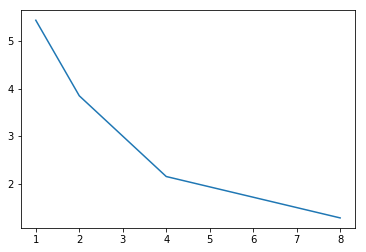

In [124]:
x = [1,2,4,8]
y_jaccard = []
for r in x:
    y_jaccard.append(df_tot[df_tot.Rate == r].Nb_Pred_Bboxes.mean())
plt.plot(x,y_jaccard)

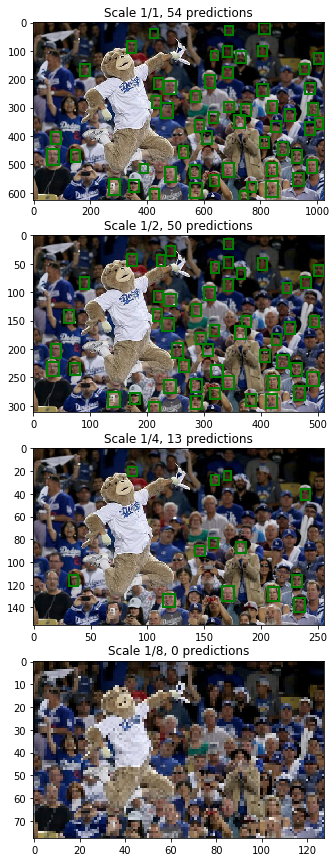

In [115]:
idx = 20
rate = 1

f_img = glob.glob(data_dir + '*')[idx]
img = cv2.imread(f_img)[:,:,::-1]
f,ax = plt.subplots(nrows=len(dico_img), figsize=(15,15))


for i, (r, img) in enumerate(dico_img.items()):
    ax[i].imshow(img[f_img.replace(data_folder, '')][:,:,::-1])
    ax[i].set_title('Scale 1/%d, %d predictions' % (r, len(predictions[r][idx])))
    for k in predictions[r][idx]:
        x1, y1 = k[:2]
        w, h = k[2] - k[0], k[3] - k[1]
        rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='g',facecolor='none')
        ax[i].add_patch(rect)